In [4]:
import numpy as np 
import scipy.stats as st 
from queue import *
import math
from distances import *
from statistics import mean 
import matplotlib.pyplot as plt


In [5]:

class Event: 
    def __init__( self, time ):
        self.time = time   
    def __lt__( self, other ):
        return self.time < other.time  
    def handle( self ):
        """updates the global simulation clock time to the class's current time attribute
        preconditions: none"""
        global simulationclock
        simulationclock = self.time
    
class NewRequest(Event, object): #An arrival occurs 
    def __init__( self, time):
        """creates a new object of class NewRequest and sets the class time attribute to the time argument
        Preconditions: time is the desired simulation clock time of the NewRequest"""
        super(NewRequest, self).__init__( time )
    def __lt__( self, other ):
        return self.time < other.time   
    def handle( self ):
   
        super(NewRequest, self).handle() # inherit operations in the function in the base class, simulation clock updated to the time when the arrival event occurs
        center = getBC()
        # request = Request(nextId, center, simulationclock, None )
        request = Request(center, simulationclock, None )
        # nextId += 1 
        eventlist.put( NewRequest( simulationclock + arrivaltime() ) )
        closest_mechanic_center, distance = closest_available_mechanic(request.center, bc_list)
        if closest_mechanic_center == None:
            requestQueue.append(request) 
        elif closest_mechanic_center == DispatchCenter: 
            DispatchCenter.num_mechs -= 1
            eventlist.put(mech_Arrives(simulationclock+(distance/60), request.center, request)) 
        else: 
            eventlist.put(mech_Arrives(simulationclock+(distance/60), request.center, request))
            closest_mechanic_center.free_mechanics -= 1
            closest_mechanic_center.number_of_mechanics -=1


class mech_Arrives(Event, object): 
    def __init__(self, time, business_center, request): 
        super(mech_Arrives, self).__init__(time)
        self.business_center = business_center
        self.request = request
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        """update the global simulation time to the event time, schedule the end of the diagnosis for 
        diagnosis_time later, and increase the number of busy mechanics at the business center by 1"""
        super(mech_Arrives, self).handle()
        self.request.time_responded = (simulationclock - self.request.timeEntered)*60
        time_to_respond_avg.append(self.request.time_responded) if simulationclock>t else None
        diag_time = diagnosis_Time(self.business_center)
        self.business_center.number_of_mechanics += 1 
        eventlist.put(diag_ends(simulationclock+ diag_time, self.business_center))
        
        

class diag_ends(Event, object):
    def __init__(self, time, business_center):
        super(diag_ends, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        super(diag_ends, self).handle()
        BC_prob = np.random.uniform(0,1)
        options = ['repair', 'replace']
        outcome_probabilities = np.array([0.8195, 0.1805])
        outcome = np.random.choice(options, 1, p = outcome_probabilities)[0]   
        if outcome == 'repair':
            eventlist.put(repair_start(simulationclock, self.business_center))
        else:
            eventlist.put(call_van(simulationclock, self.business_center))

class repair_start(Event, object): 
    def __init__(self, time, business_center): 
        super(repair_start, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self): 
        super().handle()

        eventlist.put(repair_end(simulationclock+ repair_time(), self.business_center))


class repair_end(Event, object):
    def __init__(self, time, business_center): 
        super(repair_end, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self): 
        super(repair_end, self).handle()
        eventlist.put(mechanic_leaves_business_center(simulationclock, self.business_center))           

            
class mech_goes_to_dispatch(Event,object): 
    def __init__(self, time):
        super(mech_goes_to_dispatch,self).__init__(time)
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        super(mech_goes_to_dispatch,self).handle()
        DispatchCenter.num_mechs += 1
        if len(requestQueue>0):
            req = requestQueue[0]
            requestQueue.remove(req)
            dist = distances.at['Dis', req.center.name]
            travel_time = dist/60
            eventlist.put(mech_Arrives(simulationclock+travel_time, req.center, req))
            DispatchCenter.num_mechs -= 1
            

        


####### REPLAACEMENT STARTS HERE
class call_van(Event,object):
    def __init__(self, time, business_center):
        super().__init__( time )
        self.business_center = business_center
    def handle(self):
        super(call_van,self).handle()
        copier_request =  Request(self.business_center, simulationclock, None)
        if DispatchCenter.available_vans > 0: 
            DispatchCenter.available_vans -= 1 
            dist = distances.at['Dis', copier_request.center.name]
            travel_time = dist/60
            eventlist.put(van_arrives_at_bc(simulationclock+travel_time, self.business_center, copier_request))           
        else:
            copierQueue.put(copier_request)
        eventlist.put(mechanic_leaves_business_center(simulationclock, self.business_center))           


class mechanic_leaves_business_center(Event, object):
    def __init__(self, time, business_center):
        super().__init__( time )
        self.business_center = business_center
    def handle(self):
        if len(requestQueue)==0:
            self.business_center.free_mechanics += 1
        else: 
            req = closest_request(self.business_center)
            dist = distances.at[req.center.name, self.business_center.name]
            travel_time = dist/60
            eventlist.put(mech_Arrives(simulationclock+travel_time, req.center, req))
            self.business_center.number_of_mechanics -= 1 

            
     
                
class van_arrives_at_bc(Event, object):
    def __init__(self, time, business_center, copier_request ):
        super().__init__( time )
        self.business_center = business_center
        self.copier_request = copier_request
    def handle(self):
        super(van_arrives_at_bc, self).handle()
        eventlist.put(van_returns_to_dispatch(simulationclock+swaptime_customer(), self.business_center, self.copier_request))
        


class van_returns_to_dispatch(Event, object):
    def __init__(self, time, business_center, copier_request):
        super().__init__(time)
        self.business_center = business_center
        self.copier_request = copier_request
    def handle(self):
        super(van_returns_to_dispatch, self).handle()
        self.copier_request.time_responded = (simulationclock - self.copier_request.timeEntered)*60
        copier_req_times.append(self.copier_request.time_responded) if simulationclock>t else None
        dist = distances.at['Dis', self.business_center.name]
        travel_time = dist/60 
        eventlist.put(van_swaps_copiers(simulationclock+travel_time))  

                      
class van_swaps_copiers(Event, object):
    def __init__(self, time):
        super().__init__(time)
    def handle(self):
        super(van_swaps_copiers, self).handle()
        eventlist.put(vans_finishes_swap(simulationclock + swaptime_dispatch()))
            
class vans_finishes_swap(Event, object):
    def __init__(self, time):
        super().__init__(time)
    def handle(self):
        super(vans_finishes_swap , self).handle()
        if copierQueue.empty():
            DispatchCenter.available_vans += 1
        else:
            cop_req = copierQueue.get()
            dist = distances.at['Dis', cop_req.center.name]
            travel_time = dist/60
            eventlist.put(van_arrives_at_bc(simulationclock+travel_time, cop_req.center, cop_req))
            

    

class Request(object): 
    def __init__( self, center, timeEntered, time_responded=None ):
        self.center = center
        # self.id = id      
        self.timeEntered = timeEntered
        self.time_responded = time_responded

def arrivaltime(): #Comes from input analysis question 6  
    global arrivalrate
    time_of_day = simulationclock%24
    if time_of_day < 22 and time_of_day >3: 
        arrivalrate = (-0.067*(time_of_day**2)) + 1.581*(time_of_day) - 1.289 
    else: 
        arrivalrate = 1.137 
        
    return np.random.exponential( 1 / arrivalrate )

def swaptime_dispatch(): #Service time to swap at the dispatch center, keeping everything in hours 
    return np.random.triangular(left=10/60, mode=15/60, right=25/60)

def swaptime_customer(): #Service time to swap at customer loctation 
    return np.random.triangular(left=20/60, mode=30/60, right = 1)
        
# def repair_time():
#     return st.beta.rvs(2.6158007964976218, 7.460626334186162, -0.0077049330279426054, 1.557915557823419, size=1)[0]

def diagnosis_Time(bc):
    if bc.name in ['BC_2', 'BC_3', 'BC_9']:
        return 1/60*np.random.normal(22.15, 5.34)
    else: 
        return 1/60*np.random.normal(16.13, 2.89)


def closest_available_mechanic(business_center, bc_list):
    available_mechanic_centers = []
    for x in bc_list:
        if x.free_mechanics > 0:
            available_mechanic_centers.append(x)
    if len(available_mechanic_centers)==0 and DispatchCenter.num_mechs ==0:
        return None, None
        

    if len(available_mechanic_centers)==0:
        if DispatchCenter.num_mechs > 0:
            disp_dist = distances.at['Dis', business_center.name]
            return DispatchCenter, disp_dist

        
    
    min_dist_center = available_mechanic_centers[0]
    min_dist = distances.at[min_dist_center.name, business_center.name]

    for y in available_mechanic_centers:
        dist = distances.at[y.name, business_center.name]
        if dist < min_dist:
            min_dist = dist
            min_dist_center = y
    if DispatchCenter.num_mechs != 0:
        disp_dist = distances.at['Dis', business_center.name]
        if disp_dist < min_dist:
            min_dist = disp_dist
            min_dist_center = DispatchCenter
  
    return min_dist_center, min_dist


def closest_request(BC):
    closest_req=requestQueue[0]
    closest_dist=distances.at[BC.name, closest_req.center.name]
    for req in requestQueue:
        if distances.at[BC.name, req.center.name] < closest_dist:
            closest_dist=distances.at[BC.name, req.center.name]
            closest_req=req
    requestQueue.remove(closest_req)
    return closest_req



    

In [6]:
class business_center(object):
    def __init__( self, name, coordinates, number_of_mechanics=0, number_of_vans=0, free_mechanics=0):
        self.name=name
        self.coordinates = coordinates
        self.number_of_mechanics = number_of_mechanics
        self.number_of_vans = number_of_vans
        self.free_mechanics = free_mechanics

In [7]:
class van(object):
    def __init__( self, busy=False, current_location=0, broken=False):
        self.busy = busy
        self.current_location = current_location 
        self.broken = broken

In [8]:
class dispatch(object):
    def __init__(self, coordinates, available_vans, num_mechs):
        self.coordinates = coordinates
        self.available_vans = available_vans
        self.num_mechs = num_mechs


In [9]:
class mechanic(object):
    def __init__(self, busy=False, current_location=0):
        self.busy = busy
        self.current_location= current_location


In [10]:
bc_coords = [[6,10],[4,8],[4,6],[1,6],[1,7],[9,3],[11,3],[9,2],[9,1],[11,1]]
bc_names = ['BC_1', 'BC_2', 'BC_3', 'BC_4', 'BC_5', 'BC_6', 'BC_7', 'BC_8', 'BC_9', 'BC_10']

# bc_list = []
# for i in range(len(bc_coords)):
#     bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
def getBC():
    BC_prob = np.random.uniform(0,1)
    probabilities = np.array([0.039509, 0.082089, 0.107916, 0.135418, 0.118386, 
                              0.055005, 0.123830, 0.057937, 0.137512, 0.142398])
    return np.random.choice(bc_list, 1, p = probabilities)[0]

In [11]:

# mec_avgs=[]
# van_avgs=[]
# t=100
# T= 200
# B=100
# for i in range(B):
#     simulationclock = 0
#     requestQueue = []
#     copierQueue = Queue()
#     avail_vans = 3
#     num_mechs = 7
#     DispatchCenter = dispatch([5,2], avail_vans, num_mechs)
#     eventlist = PriorityQueue()
#     bc_list = []
#     for i in range(len(bc_coords)):
#         bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
#     a = NewRequest(0)
#     eventlist.put( a )
#     time_to_respond_avg = []
#     copier_req_times = []
    
#     while simulationclock < T:
#         e = eventlist.get()
#         e.handle()

#     mec_avgs.append(np.mean(np.array(time_to_respond_avg)))
#     van_avgs.append(np.mean(np.array(copier_req_times)))
    
        
        



In [13]:
# print("Mech Average:", mean(mec_avgs))
# print("Van Average:", mean(van_avgs))



In [22]:
#mean and standard errors of the estimates
mec_avgs_std=[]
mec_se_std=[]
van_avgs_std=[]
van_se_std=[]
t=50
T=100
B=50
alpha=2.6158007964976218
beta=7.460626334186162
# ****SENSITIVITY ANALYSIS PART****
#Looping Through Perturbed Values
beta_adjusts=np.linspace(start=-1.0, stop=1.0, num=50)
for j in beta_adjusts:
    #Altering beta values 
    #copy in function that we want to look at
    def repair_time():
        return max(st.beta.rvs(alpha,beta+j, -0.0077049330279426054, 1.557915557823419, size=1)[0],0)

    mec_avgs=[]
    van_avgs=[]
    for i in range(B):
        #initialize simulation
        simulationclock = 0
        requestQueue = []
        copierQueue = Queue()
        avail_vans = 3
        num_mechs = 7
        DispatchCenter = dispatch([5,2], avail_vans, num_mechs)
        eventlist = PriorityQueue()
        bc_list = []
        for i in range(len(bc_coords)): 
            bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
        a = NewRequest(0)
        eventlist.put( a )
        time_to_respond_avg = []
        copier_req_times = []
        #run simulation
        while simulationclock < T:
            e = eventlist.get()
            e.handle()
        #record the averages
        mec_avgs.append(np.mean(np.array(time_to_respond_avg)))
        van_avgs.append(np.mean(np.array(copier_req_times)))
    
    #keep track of mean and se
    mec_avgs_std.append(np.mean(np.array(mec_avgs)))
    mec_se_std.append(np.std(np.array(mec_avgs))/np.sqrt(B))
    van_avgs_std.append(np.mean(np.array(van_avgs)))
    van_se_std.append(np.std(np.array(van_avgs))/np.sqrt(B))

In [23]:
print(np.mean(mec_avgs_std))

41.423548299724644


41.423548299724644
[42.6752591560361, 42.993851817043094, 46.667016740723746, 44.95926042538779, 45.214439840468685, 42.704045444301265, 44.37516329238441, 42.038702531283, 44.66083063089269, 44.80585709068374, 42.71686142655004, 43.21903745831264, 41.64661536743489, 43.16696105506662, 42.68092071885868, 44.0816300926024, 40.57740175507348, 41.78473199544578, 43.94803805661106, 42.86076866089235, 40.001502099793385, 40.04619841137819, 41.81197391957469, 40.844425739349816, 42.271514516279005, 40.87030946981121, 39.88527254453317, 43.38822208078733, 40.58291291803161, 40.51951672312898, 40.52887598335991, 41.183003178576676, 39.838109283518726, 41.5732111128283, 38.94078729609307, 40.94062114357217, 38.827792007575475, 40.4499763441413, 38.42144195571647, 41.19697103743645, 39.494389283287916, 39.39524934857409, 39.487060267406896, 40.155541676954584, 39.969329182459106, 38.56369335183371, 40.01649519979783, 38.613933442679446, 38.338963855129684, 37.24272805657056]


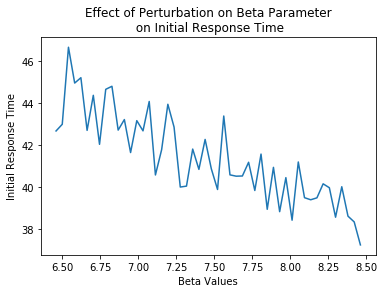

In [24]:
print(np.mean(mec_avgs_std))
new_beta_vals=beta_adjusts + 7.460626334186162
plt.plot(new_beta_vals, mec_avgs_std)
plt.xlabel("Beta Values")
plt.ylabel("Initial Response Time")
plt.title("Effect of Perturbation on Beta Parameter\n on Initial Response Time")
print(mec_avgs_std)


142.59390221033607


Text(0.5, 1.0, 'Effect of Perturbation on Beta Parameter\n on Van Response Times')

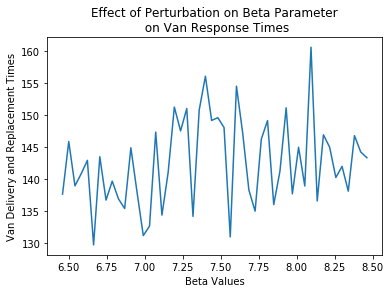

In [25]:
print(np.mean(van_avgs_std))
plt.plot(new_beta_vals, van_avgs_std)
plt.xlabel("Beta Values")
plt.ylabel("Van Delivery and Replacement Times")
plt.title("Effect of Perturbation on Beta Parameter\n on Van Response Times")



In [26]:
#mean and standard errors of the estimates
mec_avgs_std2=[]
mec_se_std2=[]
van_avgs_std2=[]
van_se_std2=[]
t=50
T=100
B=50
alpha=2.6158007964976218
beta=7.460626334186162

# ****SENSITIVITY ANALYSIS PART****
#Looping Through Perturbed Values 
alpha_adjusts=np.linspace(start=-1.0, stop=1.0, num=50)

for j in alpha_adjusts:
    #copy in function that we want to look at
    #Altering the alpha values 
    def repair_time():
        return max(st.beta.rvs(alpha+j,beta, -0.0077049330279426054, 1.557915557823419, size=1)[0],0)

    mec_avgs=[]
    van_avgs=[]
    for i in range(B):
        #initialize simulation
        simulationclock = 0
        requestQueue = []
        copierQueue = Queue()
        avail_vans = 3
        num_mechs = 7
        DispatchCenter = dispatch([5,2], avail_vans, num_mechs)
        eventlist = PriorityQueue()
        bc_list = []
        for i in range(len(bc_coords)): 
            bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
        a = NewRequest(0)
        eventlist.put( a )
        time_to_respond_avg = []
        copier_req_times = []
        #run simulation
        while simulationclock < T:
            e = eventlist.get()
            e.handle()
        #record the averages
        mec_avgs.append(np.mean(np.array(time_to_respond_avg)))
        van_avgs.append(np.mean(np.array(copier_req_times)))
    
    #keep track of mean and se
    mec_avgs_std2.append(np.mean(np.array(mec_avgs)))
    mec_se_std2.append(np.std(np.array(mec_avgs))/np.sqrt(B))
    van_avgs_std2.append(np.mean(np.array(van_avgs)))
    van_se_std2.append(np.std(np.array(van_avgs))/np.sqrt(B))

41.95227370302976
[33.24270269370925, 34.152790599289595, 33.017187571918136, 36.625469491764186, 34.07670367874089, 35.19347952705841, 35.14376847685567, 34.75039722202388, 36.50767311657664, 35.61075438623921, 34.75565983300014, 37.04780879828509, 37.520035482390185, 37.917604002305474, 38.71165303523615, 37.43098242823159, 39.75614382477152, 39.50467577176623, 38.88471057161417, 39.152021101409744, 40.267919601303646, 41.08456682824017, 39.64476834409381, 40.89705103940267, 43.20157048901773, 43.35822613392423, 42.03953199641424, 44.91109813616722, 42.46219568668852, 43.10866437249173, 44.598913815511004, 43.00416125955748, 43.73953296997488, 44.42705887134987, 46.643431776149974, 45.00166755192985, 45.60165746076754, 46.402811640374104, 49.32570614529337, 45.378982293598185, 47.85067588652559, 46.744344540281894, 46.07336982762509, 49.28508905919001, 49.76644391680491, 51.092229107972386, 49.26306863706326, 50.944221104312625, 52.90296099764311, 49.58954404863268]


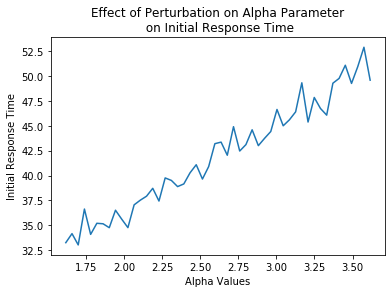

In [27]:
print(np.mean(mec_avgs_std2))
new_alpha_vals=alpha_adjusts + 2.6158007964976218
plt.plot(new_alpha_vals, mec_avgs_std2)
plt.xlabel("Alpha Values")
plt.ylabel("Initial Response Time")
plt.title("Effect of Perturbation on Alpha Parameter\n on Initial Response Time")
print(mec_avgs_std2)



142.86674376049396


Text(0.5, 1.0, 'Effect of Perturbation on Alpha Parameter\n on Van Response Times')

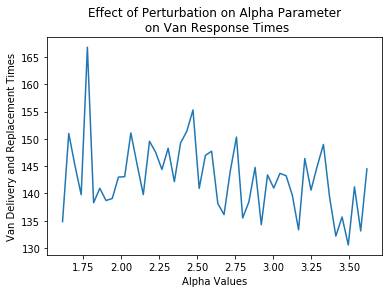

In [28]:
print(np.mean(van_avgs_std2))
plt.plot(new_alpha_vals, van_avgs_std2)
plt.xlabel("Alpha Values")
plt.ylabel("Van Delivery and Replacement Times")
plt.title("Effect of Perturbation on Alpha Parameter\n on Van Response Times")
